# Experiment 2: Raw scan to scan registration

### Goal: use VICET to bound error in LIDAR odometry when initializing LOAM from a moving platform 

In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-07-24 22:29:49.476650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 22:29:49.582937: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-24 22:29:49.938539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-24 22:29:49.938586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-24 22:29:50.614590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 22:29:50.615252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 22:29:50.615431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 22:29:50.615554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#load HD Map
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [3]:
#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

In [6]:
#put HD Map and new scan in frame of raw keyframe scan
idx = 2700 #2750 
# idx = 2020 #test
# idx = 3030 #2nd slow part
# idx = 280 #static start in alcove
skip = 55 #10 #how many lidar frames between keyframe and new scan
offset = 10 #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform everything to pc1 frame
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

# #(just run once to get ICET object into notebook so we can use associated functions)
# it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
#                draw = False, group = 2, RM = False, DNN_filter = False)

#remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
pc1_too_close = tf.where(pc1_spherical[:,0] < 2. )[:,0]
pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
print(len(pc1_too_close))
pc1 = pc1[pc1_not_too_close.numpy()]
# disp.append(Points(pc1[pc1_too_close.numpy()], c = 'black', r = 5)) #red

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

2036


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [8]:
#run VICET
from linear_corrector import LC
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 35, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
#         fid = 50, niter = 100, draw = True, mnp = 50, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 100, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 50, niter = 50, draw = True, mnp = 50, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [-0.00696497  0.04370298  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0081  0.0298 -0.0112 -0.0056  0.0005 -0.0001] 
 [-0.0062 -0.0205 -0.0081  0.001   0.0017  0.0026]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0096  0.0181 -0.0184 -0.0099  0.0008 -0.0001] 
 [-0.0083 -0.0362 -0.0142  0.002   0.003   0.0045]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0122  0.005  -0.0235 -0.0132  0.0011  0.    ] 
 [-0.0087 -0.0443 -0.0174  0.0029  0.0039  0.0058]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0143 -0.0055 -0.0263 -0.0156  0.0014  0.0001] 
 [-0.0097 -0.0512 -0.019   0.0035  0.0045  0.0069]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0162 -0.0143 -0.0279 -0.0176  0.0016  0.0002] 
 [-0.0107 -0.0569 -0.0199  0.0043  0.005   0.0078]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0181 -0.0216 -0.0287 -0.0193  0.0017  0.0002] 
 [-0.0116 -0.0616 -0.0204  0.005   0.0054  0.0085]
~~~~

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
#run rigid ICET
it = ICET(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
# ax.plot(np.diff(poses[:,0,3]))
# ax.plot(np.diff(poses[:,1,3]))
# ax.plot(np.diff(np.sqrt(poses[:,1,3]**2 + poses[:,0,3]**2)))
ax.plot(np.sqrt(np.diff(poses[:,1,3])**2 + np.diff(poses[:,0,3])**2))

## Load LOAM Trajectory Initialzied From Moving Platform

In [ ]:
# # start at 2400 (corner near tree) very obvious forward motion distortion
# # rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag

# ## start at 2800
# # # rosbag play --clock -s 110.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# LOAM = np.load("results/LOAM/05_LOAM_start_from_2800_v1.npy")
# start_idx = 2810

# # rosbag play --clock -s 100.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
LOAM = np.load("results/LOAM/05_LOAM_start_from_2700_v1.npy")

#  Plot on HD Map

In [ ]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

fn = "results/LOAM/05_LOAM_start_from_2700_v1.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 2689 #2690

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(0), 0]).as_matrix() #was this for 678
rot_mat = R.from_euler('xyz', [np.deg2rad(10), np.deg2rad(31), np.deg2rad(5.5)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
# gt_lidarframe = (poses[start_idx] @ np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)
# gt_lidarframe = (np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T

gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, r = ptsize).legend("LOAM")
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
# rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix() #old
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

# lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

In [ ]:
from matplotlib import pyplot as plt

# view_len = 50 #ideal
view_len = 100
# view_len = len(LOAM_corr) #show all data
A_hist = np.load('results/VICET/VICET_constant_keyframe_05_start_from_2700_v1.npy')

fig,ax = plt.subplots(2,1)
ax[0].set_title("X World Frame, moving start at 2700")
ax[0].set_ylabel("Translation (m)")
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0] + A_hist[:view_len,0], label = 'VICET', color = 'C0')
ax[0].plot(LOAM_corr[:view_len,0], label = 'LOAM', color = 'C1')
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0], 'k--', label = 'ground truth')
ax[0].legend(loc='best')

ax[1].set_title("Y World Frame, moving start at 2700")
ax[1].set_ylabel("Translation (m)")
ax[1].set_xlabel("Frame Index")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1] + A_hist[:view_len,1], label = 'VICET', color = 'C0')
ax[1].plot(LOAM_corr[:view_len,1], label = 'LOAM', color = "C1")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1], 'k--', label = 'ground truth')
ax[1].legend(loc='best')

### Find ~50 frame region where VICET doesn't explode

In [ ]:
from linear_corrector import LC #VICET
st = time.time()

runlen = 100 #50
start_idx = 2700
# start_idx = 1800 #test
# start_idx = 2020

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_stds = np.zeros([runlen,12])
X_hist = np.zeros([runlen, 6]) #ICET/ NDT
X_hist_ICP = np.zeros([runlen, 6]) #ICP
raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #9 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + offset) + ".npy"
    pc1 = np.load(fn1)
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc2 = np.load(fn2)
    #remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
    pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
    pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
    pc1 = pc1[pc1_not_too_close.numpy()]

    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
#     submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ poses[start_idx+idx] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    dc = LC(cloud1 = pc1, cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 55, niter = 50, draw = False, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)
    A_hist[idx,:] = dc.A
    VICET_pred_stds[idx,:] = dc.pred_stds
#     np.save("results/VICET/VICET_constant_keyframe_05_start_from_2700_v1", A_hist)

In [ ]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(3,1)
ax[0].set_title("Raw Scan-to-Scan Registration Error")
ax[0].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[0].plot(A_hist[:,0], label = 'Error in VICET registration', color = 'C0')
ax[0].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,6]),
                y2 = -abs(A_hist[:,6]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[0].set_xlabel("Frame since keyframe scan")
ax[0].set_ylabel("Translation Error in X (m)")
ax[0].legend(loc = 'best')

ax[1].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[1].plot(A_hist[:,1], label = 'Error in VICET registration', color = "C0")
ax[1].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,7]),
                y2 = -abs(A_hist[:,7]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[1].set_xlabel("Frame since initial scan")
ax[1].set_ylabel("Translation Error in Y (m)")
# ax[1].legend(loc = 'best')

ax[2].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[2].plot(np.rad2deg(A_hist[:,5]), label = 'Error in VICET registration', color = "C0")
ax[2].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(np.rad2deg(A_hist[:,11])),
                y2 = -abs(np.rad2deg(A_hist[:,11])), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
ax[2].set_xlabel("Frame since initial scan")
ax[2].set_ylabel("Rotation Error in Yaw (deg)")
# ax[2].legend(loc = 'best')

# np.save("results/VICET/VICET_constant_keyframe_05_start_from_1800_v1", A_hist)

# compare with LOAM errors for frames 1800-1850 (moving start):

In [9]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

# fn = "results/LOAM/05_LOAM_start_from_1800_v1.npy"
fn = "results/LOAM/05_LOAM_start_from_1800_v2.npy"
# fn = "results/LOAM/05_LOAM_start_from_1790_v1.npy"# start_idx = 1789
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]
# LOAM_traj =  LOAM_traj[2:,:] - LOAM_traj[2,:] #might looks better??

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 1799 #1800 

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

rot_mat = R.from_euler('xyz', [np.deg2rad(2.), np.deg2rad(50.25), np.deg2rad(0)]).as_matrix() #was this
# rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(46.5), np.deg2rad(0)]).as_matrix() #for 1790
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)

gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(-110)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

A_hist = np.load('results/VICET/VICET_constant_keyframe_05_start_from_1800_v1.npy')

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Plot LOAM Odometry with VICET Error Bounds

<IPython.core.display.Javascript object>


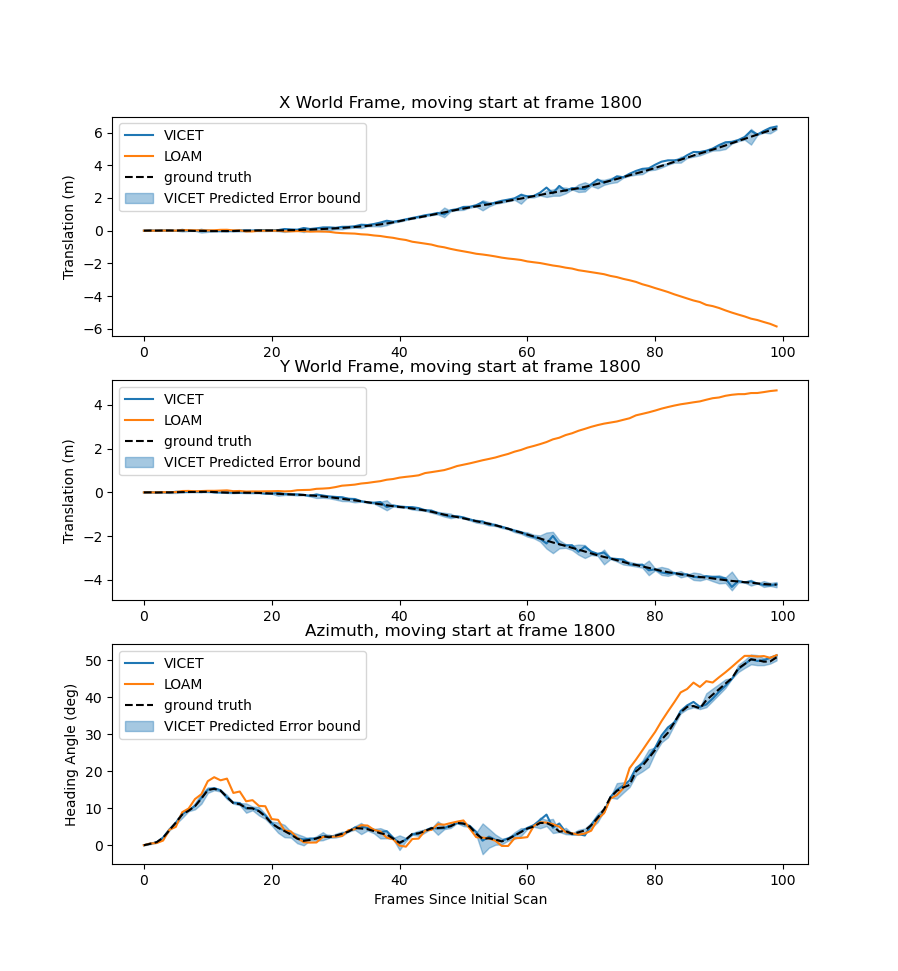

[[ 0.01863125  0.00794109 -1.15053606]
 [ 0.01781582  0.00745894 -1.15078797]
 [ 0.01784549  0.00808935 -1.15075126]
 ...
 [ 0.02380293 -0.04506448  0.40865244]
 [ 0.02475722 -0.04389498  0.40391867]
 [ 0.02481602 -0.04397652  0.40855823]]


In [34]:
from matplotlib import pyplot as plt
# view_len = 50 #works best
view_len = len(A_hist) #show all data (need to comment out bounds)

fig,ax = plt.subplots(3,1)

ax[0].set_title("X World Frame, moving start at frame 1800")
# ax[0].set_title("X World Frame, static start")
ax[0].set_ylabel("Translation (m)")
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0] + A_hist[:view_len,0],
           label = 'VICET', color = 'C0')
ax[0].plot(LOAM_corr[:view_len,0], label = 'LOAM', color = "C1")
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0], 'k--', label = 'ground truth')
ax[0].fill_between(np.linspace(0,view_len-1, view_len), 
                y1 = gt_lidarframe[start_idx:start_idx+view_len,0] + abs(A_hist[:view_len,6]),
                y2 = gt_lidarframe[start_idx:start_idx+view_len,0] - abs(A_hist[:view_len,6]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[0].legend(loc='best')

ax[1].set_title("Y World Frame, moving start at frame 1800")
# ax[1].set_title("Y World Frame, static start")
ax[1].set_ylabel("Translation (m)")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1] + A_hist[:view_len,1], label = 'VICET', color = 'C0')
ax[1].plot(LOAM_corr[:view_len,1], label = 'LOAM', color = "C1")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1], 'k--', label = 'ground truth')
ax[1].legend(loc='best')
ax[1].fill_between(np.linspace(0,view_len-1, view_len), 
                y1 = gt_lidarframe[start_idx:start_idx+view_len,1] + abs(A_hist[:view_len,7]),
                y2 = gt_lidarframe[start_idx:start_idx+view_len,1] - abs(A_hist[:view_len,7]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[1].legend(loc='best')

#was this
# gt_euls = R.from_quat(qxyzw).as_euler('xyz') 
#correct for axis palcement at initial pose??
gt_euls = R.from_matrix(np.linalg.pinv(poses[start_idx,:3,:3]) @ R.from_quat(qxyzw).as_matrix()).as_euler('xyz')  

print(gt_euls)

ax[2].set_title("Azimuth, moving start at frame 1800")
# ax[2].set_title("Azimuth, static start")
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]) + np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - gt_euls[start_idx,2]), label = 'LOAM')
ax[2].plot(np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - gt_euls[start_idx,2] + A_hist[:view_len,5]), label = 'VICET', color = "C0")
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]), label = 'LOAM', color = "C1")
#NOTE: need to account for offset in gt_euls (only in some trials)
ax[2].plot(np.rad2deg(LOAM_traj[2:view_len+2,4] - LOAM_traj[2,4])  , label = 'LOAM', color = "C1")
ax[2].plot(np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - gt_euls[start_idx,2]), 'k--', label = 'ground truth')
ax[2].set_xlabel("Frames Since Initial Scan")
ax[2].set_ylabel("Heading Angle (deg)")
ax[2].fill_between(np.linspace(0,view_len-1, view_len), 
                y1 = np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] + abs(A_hist[:view_len,11]) - gt_euls[start_idx,2]),
                y2 = np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - abs(A_hist[:view_len,11]) - gt_euls[start_idx,2]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[2].legend(loc = 'best')

<IPython.core.display.Javascript object>


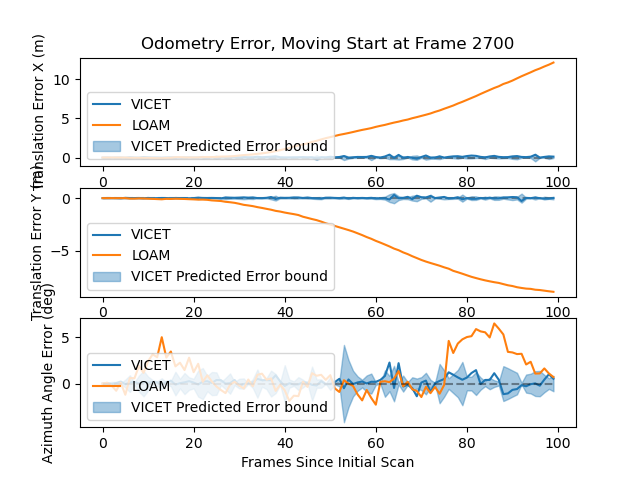

In [35]:
#plot error vs error bounds
from matplotlib import pyplot as plt
# view_len = 50 #works best
view_len = len(A_hist) #show all data

fig,ax = plt.subplots(3,1)
ax[0].set_title("Odometry Error, Moving Start at Frame 2700")
ax[0].set_ylabel("Translation Error X (m)")
ax[0].plot(np.zeros(view_len), 'k--', alpha = 0.4)
ax[0].plot(A_hist[:view_len,0], label = 'VICET', color = 'C0')
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len, 0] - LOAM_corr[:view_len,0], label = 'LOAM', color='C1')
ax[0].fill_between(np.linspace(0,view_len-1, view_len), 
                y1 =  abs(A_hist[:view_len,6]),
                y2 = -abs(A_hist[:view_len,6]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[0].legend(loc='lower left')

# ax[1].set_title("Y Error, moving start")
ax[1].set_ylabel("Translation Error Y (m)")
ax[1].plot(np.zeros(view_len), 'k--', alpha = 0.4)
ax[1].plot(A_hist[:view_len,1], label = 'VICET', color = 'C0')
# ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len, 1] - LOAM_corr[:view_len,1], label = 'LOAM', color='C1')
frameToFrameLOAMError = gt_lidarframe[start_idx+1:start_idx+view_len+1, 1] - LOAM_corr[:view_len,1]
# frameToFrameLOAMError = gt_lidarframe[start_idx+1:start_idx+view_len+1, 1] - LOAM_corr[:view_len,1]
frameToFrameLOAMError[0] = 0
ax[1].plot(frameToFrameLOAMError, label = 'LOAM', color='C1')
ax[1].fill_between(np.linspace(0,view_len-1, view_len), 
                y1 = abs(A_hist[:view_len,7]),
                y2 = -abs(A_hist[:view_len,7]), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[1].legend(loc='lower left')
# ax[1].set_xlabel("Frames since Initial Scan")

gt_euls = R.from_quat(qxyzw).as_euler('xyz')
# ax[2].set_title("Azimuth  Error, moving start")
ax[2].plot(np.rad2deg(A_hist[:view_len,5]), label = 'VICET', color = 'C0')
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4] - gt_euls[start_idx:start_idx+view_len,2] +  gt_euls[start_idx,2] ), label = 'LOAM', color = 'C1')
# #need to account for offset between ground truth and LIDAR scan indices (only on some trials)
ax[2].plot(np.rad2deg(LOAM_traj[2:view_len+2,4] - LOAM_traj[2,4] - gt_euls[start_idx:start_idx+view_len,2] +  gt_euls[start_idx,2] ), label = 'LOAM', color = 'C1')

ax[2].plot(np.zeros(view_len), 'k--', alpha = 0.4)
ax[2].set_xlabel("Frames Since Initial Scan")
ax[2].set_ylabel("Azimuth Angle Error (deg)")
ax[2].fill_between(np.linspace(0,view_len-1, view_len), 
                y1 = np.rad2deg(abs(A_hist[:view_len,11])),
                y2 = np.rad2deg(-abs(A_hist[:view_len,11])), 
                color = 'C0', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[2].legend(loc = 'lower left')

# compare LOAM vs VICET error bound on frames ~2020-2070 (staticish start):

In [26]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

#init raw LOAM trajectory and OG LOAM axis
# fn = "results/LOAM/05_LOAM_start_from_static.npy"
# fn = "results/LOAM/05_LOAM_start_from_static_v2.npy"
fn = "results/LOAM/05_LOAM_start_from_static_v4.npy" #new 7/24-- starts 10 frames earlier
LOAM_traj = np.load(fn)
LOAM_traj =  LOAM_traj[10:,:] #for v4 -- 7/24


LOAM_axis = np.eye(3)
# start_idx = 2010 #for new test (6/28)
start_idx = 2032 #2030 #better??
end_idx = start_idx + len(LOAM_traj) #3341
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(26), np.deg2rad(-2)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(-30)]).as_matrix() #test
gt_points = Line(gt_lidarframe[2000:3000,:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)
#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

#get VICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_idx_VICET = 2020 #static start
VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v1.npy")
# VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v2.npy")
A_hist = VICET_A_hist[:100,:]

# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + 
#               VICET_A_hist[:,:3] + VICET_A_hist[:,6:9])
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])
# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3])

#line up at start
VICET_traj -= VICET_traj[0,:]
#rotate to align with gt
VICET_traj = VICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(190)]).as_matrix()

# VICET_points = Points(VICET_traj[:,:3], c='green', r=ptsize, alpha = 0.8).legend("VICET")
VICET_points = Line(VICET_traj[:,:3], lw = 3, c='green', alpha = 1).legend("VICET")
disp.append(VICET_points)

lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# start from near very beginning at frame 280 in first ROSBAG (actual static start)

In [33]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

#init raw LOAM trajectory and OG LOAM axis
fn = "results/LOAM/05_LOAM_start_from_280_v1.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:] #was this


LOAM_axis = np.eye(3)
start_idx = 290
end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(135), 0]).as_matrix() #was this for 678
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(28), 0]).as_matrix() #test
rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(26), np.deg2rad(-2)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(180)]).as_matrix() #was this
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(225)]).as_matrix() #for test 678
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(-30)]).as_matrix() #test
# gt_points = Points(gt_lidarframe[2000:3000,:3], c = "black", r=3).legend("Actual Motion of Platform")
gt_points = Line(gt_lidarframe[2000:3000,:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

#get VICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_idx_VICET = 2020 #static start
VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v1.npy")
# VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v2.npy")
A_hist = VICET_A_hist[:100,:]

# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + 
#               VICET_A_hist[:,:3] + VICET_A_hist[:,6:9])
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])
# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3])

#line up at start
VICET_traj -= VICET_traj[0,:]
#rotate to align with gt
VICET_traj = VICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(190)]).as_matrix()

# VICET_points = Points(VICET_traj[:,:3], c='green', r=ptsize, alpha = 0.8).legend("VICET")
VICET_points = Line(VICET_traj[:,:3], lw = 3, c='green', alpha = 1).legend("VICET")
disp.append(VICET_points)

lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)